In [1]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import time
import pickle
from utils import *
from extract_features import extract_features
from svm_classify import run_svm_classifier
import ProcessFrame
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Data visualization

The provided dataset contains almost similar numbers of car and non-car images. This is good news since we don't need to do additional pre-processing to balance the dataset.

In [2]:
cars, non_cars = get_filenames()
num_cars, num_non_cars = len(cars), len(non_cars)
print("Number of cars, non-cars", num_cars, num_non_cars )

Number of cars, non-cars 8792 8968


Min max values 0.027451 1.0


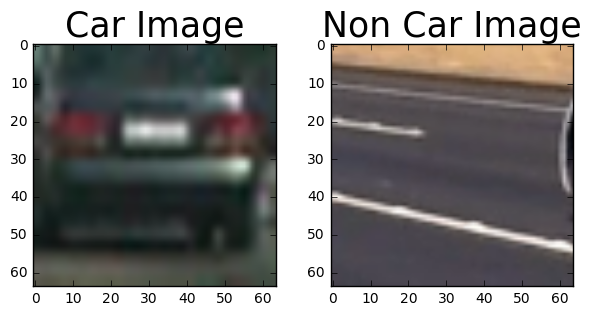

In [3]:
car_idx, non_car_idx = np.random.randint(num_cars), np.random.randint(num_non_cars)
car_img, non_car_img = mpimg.imread(cars[car_idx]), mpimg.imread(non_cars[non_car_idx])
print("Min max values", np.min(car_img), np.max(non_car_img))
show_image(car_img, non_car_img, titles=['Car Image', 'Non Car Image'], disp_flag = True)

# Feature extraction
I worked on extracting 3 sets of features for each image

** Spatial features **: These are the raw values (intensity values) of the image either in original RGB colorspace or transformed to another colorspace.

** Color histogram features **: These are the counts for each of the pixel intensities in the image. Again these could either be in the original RGB colorspace or transformed to another colorspace.

** Histogram Oriented Gradient (HOG) features **: These features capture the distribution of gradient magnitudes in the image. The idea here is to somehow capture the shape of the desired object (car in our case).


## Spatial features

Generally RGB colorspace is a poor choice for machine learning algorithms since it is very vulnerable to changes in lighting conditions. Alternate colorspaces help to isolate the influence of light on the real colors of the image. I tried the HSV, HLS and YCrCb colorspaces. They all produced reasonable results (98.5% to 99.5 % accuracies using a linear SVM classifier). In the end I chose the YCrCb colorspace since I found it resulted in fewer false positives. I also binned the images to 16x16. This had the effect of lowering the feature size (thus speeding up classification) without really affecting the accuracy.

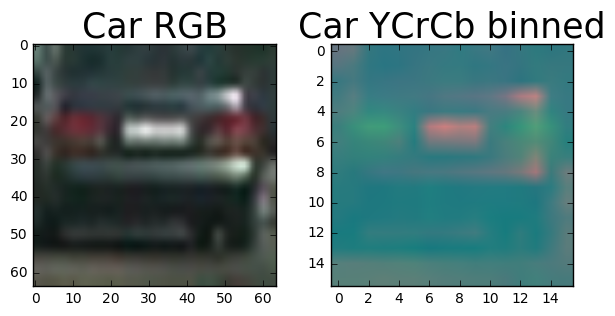

In [4]:
process_frame = ProcessFrame.ProcessFrame()
car_ycrcb = process_frame.convert_color_space(car_img, 'YCrCb')
car_ycrcb_binned = cv2.resize(car_ycrcb, (16,16))
show_image(car_img, car_ycrcb_binned, titles=['Car RGB', 'Car YCrCb binned'], disp_flag = True)

## Color histogram features ##

Since cars typically are uniformly colored in bright colors, using a histogram of the raw intensity values (same as color values) of the images could be a useful feature for identifying cars from non-cars. For my color histogram features, I generated a histogram using 32 bins for each of the Y, Cb and Cr channels 

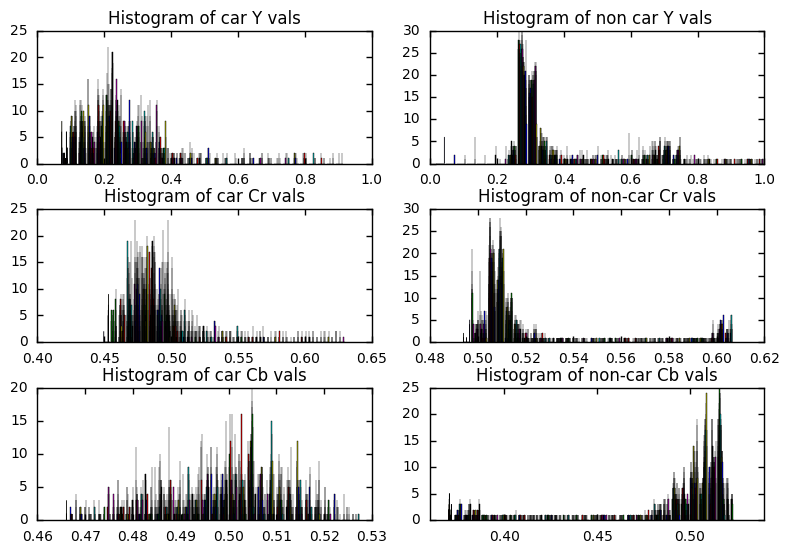

In [5]:
non_car_ycrcb = process_frame.convert_color_space(non_car_img, 'YCrCb')
nbins = 32

with plt.style.context('seaborn-notebook'):
    f = plt.figure()
    #f, (ax1, ax2, ax3) = plt.subplots(3,2)
    ax1 = f.add_subplot(321)
    ax2 = f.add_subplot(322)
    ax3 = f.add_subplot(323)
    ax4 = f.add_subplot(324)
    ax5 = f.add_subplot(325)
    ax6 = f.add_subplot(326)
    f.tight_layout()
    ax1.hist(car_ycrcb[:,:,0], bins=nbins)
    ax1.set_title("Histogram of car Y vals")
    ax2.hist(non_car_ycrcb[:,:,0], bins=nbins)
    ax2.set_title("Histogram of non car Y vals")
    ax3.hist(car_ycrcb[:,:,1], bins=nbins)
    ax3.set_title("Histogram of car Cr vals")
    ax4.hist(non_car_ycrcb[:,:,1], bins=nbins)
    ax4.set_title("Histogram of non-car Cr vals")
    ax5.hist(car_ycrcb[:,:,2], bins=nbins)
    ax5.set_title("Histogram of car Cb vals")
    ax6.hist(non_car_ycrcb[:,:,2], bins=nbins)
    ax6.set_title("Histogram of non-car Cb vals")


As can be seen above, the histogram of car YCrCb values tend to have more tightly grouped values compared to non car YCrCb images. This can potentially help the classifier distinguish between car and non-car images

## Hog features

The hog features help the classifier to capture the notion of 'shape of an object' by observing the distribution of gradient magnitudes across the object. This is achieved by dividing the entire image into 'cells' (eg. an 8x8 pixel grids for a 64x64 image). Then for each cell, the gradient magnitudes are summed up for each orientation bin of the HOG.

For this project, I used the hog function in the sci-kit image module. Tuning the parameters played a key part in getting the right features to develop a good classifier. The important parameters I played with are the *orientation* (number of orientation bins in the histogram), *pixels_per_cell* (number of pixels in each cell - each for x and y) and *cells_per_block* (number of cells in a block to perform normalization - each for x and y).The following are the final values of the parameters I played with

`Orientations`: 9, `Pixels_per_cell`: 12, `Cells_per_block`: 2

The most important parameter I played with was the pixels_per_cell. Lower pixels per cell helped improved the classifier accuracy but slowed down the sliding window search process and vice versa. 12 pixels per cell (in x and y - so a total of 144 pixels in a cell) provided the right balance between speed and accuracy.

Also note that the hog features were computed on the YCrCb color converted images, to prevent any illumination related issues

0.03 Seconds to extract features...


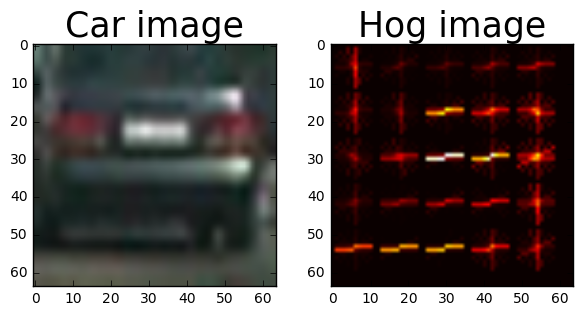

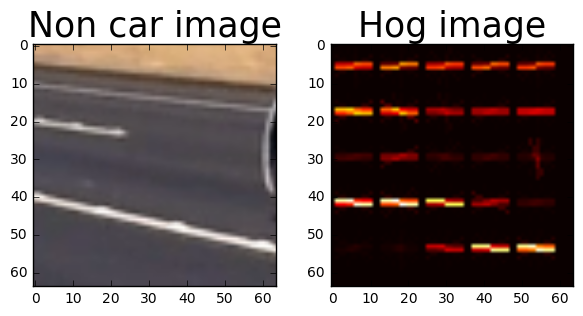

In [6]:
params = {}
# hog params
params['orient'] = 9  # 9
params['pix_per_cell'] = 12  # 6 #8 #12 works!!!!!!
params['cell_per_block'] = 2  # 2
params['hog_channel'] = 0  # "ALL" # Can be 0, 1, 2, or "ALL"

# for color and hist features
params['colorspace'] = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
params['spatial'] = 16
params['histbin'] = 32 #64 

# Flags for features
params['spatial_feat'] = True
params['hist_feat'] = True
params['hog_feat'] = True

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
cars = cars[0:sample_size]
notcars = non_cars[0:sample_size]

# Flags for features
spatial_feat=False
hist_feat=False
hog_feat=True

t=time.time()
car_features, hog_car = extract_features(car_img, [], params, hog_vis = True, single_image_flag = True)
notcar_features, hog_not_car = extract_features(non_car_img, [], params, hog_vis = True, single_image_flag = True)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

show_image(car_img, hog_car, titles=['Car image', 'Hog image'], cmaps = [None, 'hot'], disp_flag = True)
show_image(non_car_img, hog_not_car, titles=['Non car image', 'Hog image'], cmaps = [None, 'hot'], disp_flag = True)

## Training the classifier

As suggested in the lecture notes, I used a linear SVM classifier. The spatial, histogram and hog features computed above were concatenated into a single feature vector for each image. The features were then normalized inorder to reduce the effects of inter-feature variation, which is very common especially when different types of features are combined as above.For the normalization part, I used the standard scaler from the python sklearn module.

After training, the classifier and scaler were saved to a file (pickle file) for re-use when performing the sliding window search.

In [7]:
params = process_frame.setup_params()
run_svm_classifier(params, False)

Number of cars, non-cars 8792 8968
64.43 Seconds to extract features...
Using spatial binning of: 16
Using histogram bins: 32
Using: 9 orientations 12 pixels per cell and 2 cells per block
Feature vector length: 2592
4.74 Seconds to train SVC...
Test Accuracy of SVC =  0.9907


# Sliding window search

Sliding window search involves 
1. Running windows of different sizes throughout the image.
2. Extracting the features of the pixels contained in the window.
3. Applying a classifier on the features to predict the presence or absence of a car in the window.

Implementing an effective sliding window search involves a delicate balance between speed and accuracy. Let us walk through each of the steps above

### Running windows of different sizes

The sliding window search was restricted to a region of y values bounded between 400 and 650. This was the region where most of the cars appeared in the provided video. Everything outside this region (mostly horizon, trees, etc.) could be safely eliminated. This provided a significant boost in performance.

I used 2 window sizes. Window size 64 was used to search a region of y values bounded between 400 and 550 and window size 96 was used to search the full range of valid y values (400 to 650).

Another important parameter is the number of overlap pixels between adjacent windows. By adjusting the overlap between windows, one can control the coarseness of the search grid. Since I am using 12 pixels per cell (in the hog features), a 50% overlap will correspond to about 6 pixels.

Total number of windows:  63


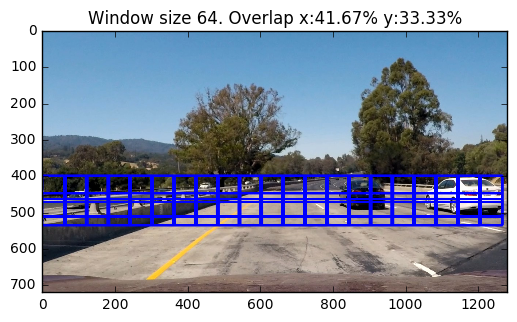

In [8]:
test_img = mpimg.imread('./test_images/test1.jpg')
show_img = test_img.copy()
slide_window_tup1 = (64, (5, 4), (400, 550))
w_size, overlap_pix, yrange = slide_window_tup1
slide_window_params = [slide_window_tup1]
# Load classifier params
svm_dict = pickle.load(open("svm_pickle.p", "rb"))
clf = svm_dict["clf"]
scaler = svm_dict["scaler"]
process_frame.find_cars(test_img, slide_window_params, svc=clf, X_scaler=scaler, params=params, show_search_windows=True)
img_boxes, search_windows = process_frame.box_dict['img_boxes'], process_frame.box_dict['search_windows']
print("Total number of windows: ", len(search_windows))
detect_car_img = draw_boxes(show_img, search_windows)
plt.imshow(detect_car_img)
plt.title("Window size {0}. Overlap x:{1:.2f}% y:{2:.2f}%".format(w_size, overlap_pix[0]*100./params['pix_per_cell'],\
                                                        overlap_pix[1]*100./params['pix_per_cell']))

Total number of windows:  28


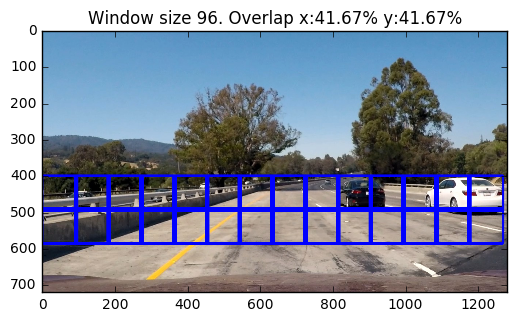

In [9]:
slide_window_tup2 = (96, (5, 5), (400, 650))
w_size, overlap_pix, yrange = slide_window_tup2
slide_window_params = [slide_window_tup2]
process_frame.find_cars(test_img, slide_window_params, svc=clf, X_scaler=scaler, params=params, show_search_windows=True)
img_boxes, search_windows = process_frame.box_dict['img_boxes'], process_frame.box_dict['search_windows']
print("Total number of windows: ", len(search_windows))
detect_car_img = draw_boxes(show_img, search_windows)
plt.imshow(detect_car_img)
plt.title("Window size {0}. Overlap x:{1:.2f}% y:{2:.2f}%".format(w_size, overlap_pix[0]*100./params['pix_per_cell'],\
                                                        overlap_pix[1]*100./params['pix_per_cell']))

### Extracting features

For each of the windows shown above, the spatial, histogram and hog features were extracted. Extracting hog features is quite expensive and it quickly became obvious that computing hog features for each window position is not efficient. So an important optimization step was to perform 'hog subsampling'. The idea here is that for each window size the hog features are computed once over the range of the image where the sliding window will be applied. Then for each window position the corresponding hog locations are determined and the hog features are sampled from those hog locations. This turns out to be way more efficient.

### Applying the classifier

The idea here is to apply the classifier (the linear SVM classifier trained on the database of car/non-car images) on each of the windows to predict the presence or absence of a car. The co-ordinates of the windows for the positive predictions were stored and drawn on the image to visualize the car predictions.

A particular problem one has to deal with is false positives. Occasionally the classifier predicts a window to be a car (even though it is not a car). This was especially true for the region containing the guard rails in the images. One way to address this problem was to use 'heat maps'. More on this in the video section below. 


Total number of search windows:  28
0.283 Seconds to process image


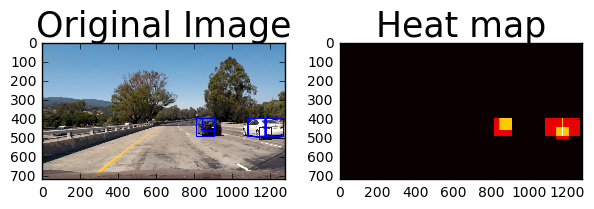

In [10]:
show_img = test_img.copy()
t1 = time.time()
slide_window_params = [slide_window_tup1, slide_window_tup2]
process_frame.find_cars(test_img, slide_window_params, svc=clf, X_scaler=scaler, params=params, show_search_windows=False)
img_boxes, search_windows = process_frame.box_dict['img_boxes'], process_frame.box_dict['search_windows']
print("Total number of search windows: ", len(search_windows))
heat_map = process_frame.box_dict['heat_map']
detect_car_img = draw_boxes(show_img, img_boxes)
t2 = time.time()
print(round(t2 - t1, 3), 'Seconds to process image')
show_image(detect_car_img, heat_map, titles=['Original Image', 'Heat map'], cmaps=[None, 'hot'], disp_flag=True)

## Additional steps for processing the video

1. All the pixels in a postive window were assigned a value (or heat) of 1. These heatmaps are then summed up over several frames of the video.
2. I used a ring buffer of length 35 (using the python deque data structure) to store and sum up the heat maps.
3. A threshold was chosen and values of pixels in the heatmap below that threshold were set to zero. The idea here is that false positives typically have 'less heat'. So by thresholding the heatmaps one can get rid of the false positives. 
4. The non zero regions in the thresholded heatmap are then labelled using the scipy label command. These regions should ideally correspond to cars in the video frame.
5. The co-ordinates of these labels are then extracted to draw a bounding box around the recognized car.

